# Import Libraries

In [33]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model2 import Net2

In [34]:
! nvidia-smi

Fri Dec 13 22:35:05 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:1E.0 Off |                    0 |
| N/A   31C    P0             32W /   70W |     407MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [35]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [36]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [37]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [38]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net2().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 12, 24, 24]             192
        MaxPool2d-10           [-1, 12, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]           1,080
             ReLU-12           [-1, 10, 10, 10]               0
      BatchNorm2d-13           [-1, 10, 10, 10]              20
          Dropout-14           [-1

# Training and Testing

All right, so we have 24M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [39]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [42]:
from torch.optim.lr_scheduler import StepLR

model =  Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.0876583531498909 Batch_id=468 Accuracy=88.22: 100%|██████████| 469/469 [00:06<00:00, 68.99it/s]  



Test set: Average loss: 0.0745, Accuracy: 9768/10000 (97.68%)

EPOCH: 1


Loss=0.023755192756652832 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:06<00:00, 68.61it/s]



Test set: Average loss: 0.0424, Accuracy: 9859/10000 (98.59%)

EPOCH: 2


Loss=0.06990454345941544 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:06<00:00, 68.88it/s] 



Test set: Average loss: 0.0367, Accuracy: 9883/10000 (98.83%)

EPOCH: 3


Loss=0.1501629501581192 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:06<00:00, 68.94it/s]  



Test set: Average loss: 0.0393, Accuracy: 9866/10000 (98.66%)

EPOCH: 4


Loss=0.10217154026031494 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:06<00:00, 69.05it/s] 



Test set: Average loss: 0.0298, Accuracy: 9904/10000 (99.04%)

EPOCH: 5


Loss=0.014181793667376041 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:06<00:00, 69.04it/s]



Test set: Average loss: 0.0305, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.0257202610373497 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:06<00:00, 68.66it/s]   



Test set: Average loss: 0.0280, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Loss=0.01954980008304119 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:06<00:00, 68.57it/s] 



Test set: Average loss: 0.0267, Accuracy: 9909/10000 (99.09%)

EPOCH: 8


Loss=0.04030486196279526 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:06<00:00, 67.68it/s]  



Test set: Average loss: 0.0286, Accuracy: 9910/10000 (99.10%)

EPOCH: 9


Loss=0.003447355702519417 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:06<00:00, 68.61it/s] 



Test set: Average loss: 0.0256, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.01773468591272831 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:06<00:00, 68.61it/s]  



Test set: Average loss: 0.0259, Accuracy: 9916/10000 (99.16%)

EPOCH: 11


Loss=0.013980783522129059 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:06<00:00, 68.68it/s]



Test set: Average loss: 0.0234, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.027053752914071083 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:06<00:00, 68.66it/s] 



Test set: Average loss: 0.0275, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


Loss=0.01860821805894375 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:06<00:00, 68.60it/s]  



Test set: Average loss: 0.0270, Accuracy: 9915/10000 (99.15%)

EPOCH: 14


Loss=0.06399743258953094 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:06<00:00, 68.62it/s]  



Test set: Average loss: 0.0263, Accuracy: 9915/10000 (99.15%)



Text(0.5, 1.0, 'Test Accuracy')

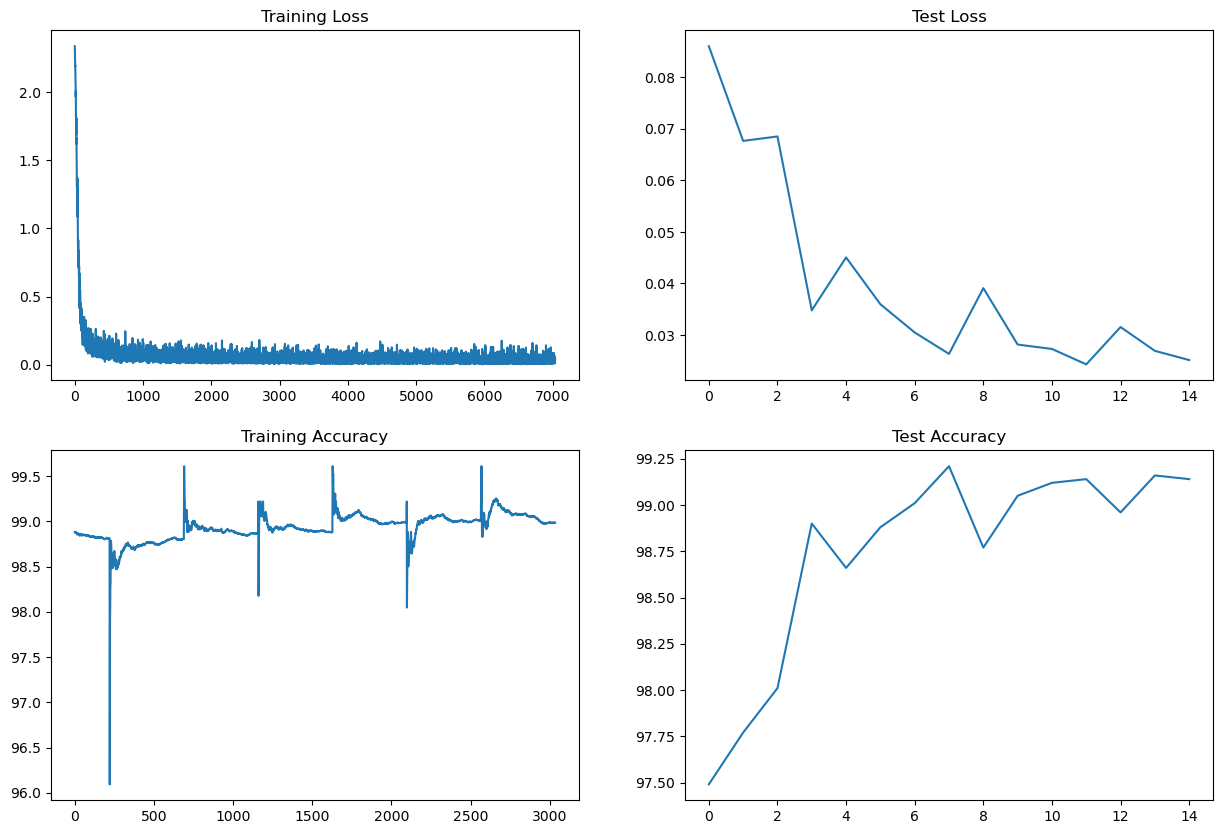

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([t.item() for t in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [17]:
fig.savefig('exp1.png')

In [18]:

import matplotlib.pyplot as plt
import numpy as np
def evaluate_model(model: nn.Module, loader, device: torch.device):
    cols, rows = 4,6
    figure = plt.figure(figsize=(20, 20))
    for i in range(1, cols * rows + 1):
        k = np.random.randint(0, len(loader.dataset)) # random points from test dataset
    
        img, label = loader.dataset[k] # separate the image and label
        img = img.unsqueeze(0) # adding one dimention
        pred=  model(img.to(device)) # Prediction 

        figure.add_subplot(rows, cols, i) # making the figure 
        plt.title(f"Predcited label {pred.argmax().item()}\n True Label: {label}") # title of plot
        plt.axis("off") # hiding the axis
        plt.imshow(img.squeeze(), cmap="gray") # showing the plot

    plt.show()
    plt.savefig('eval_1.png')

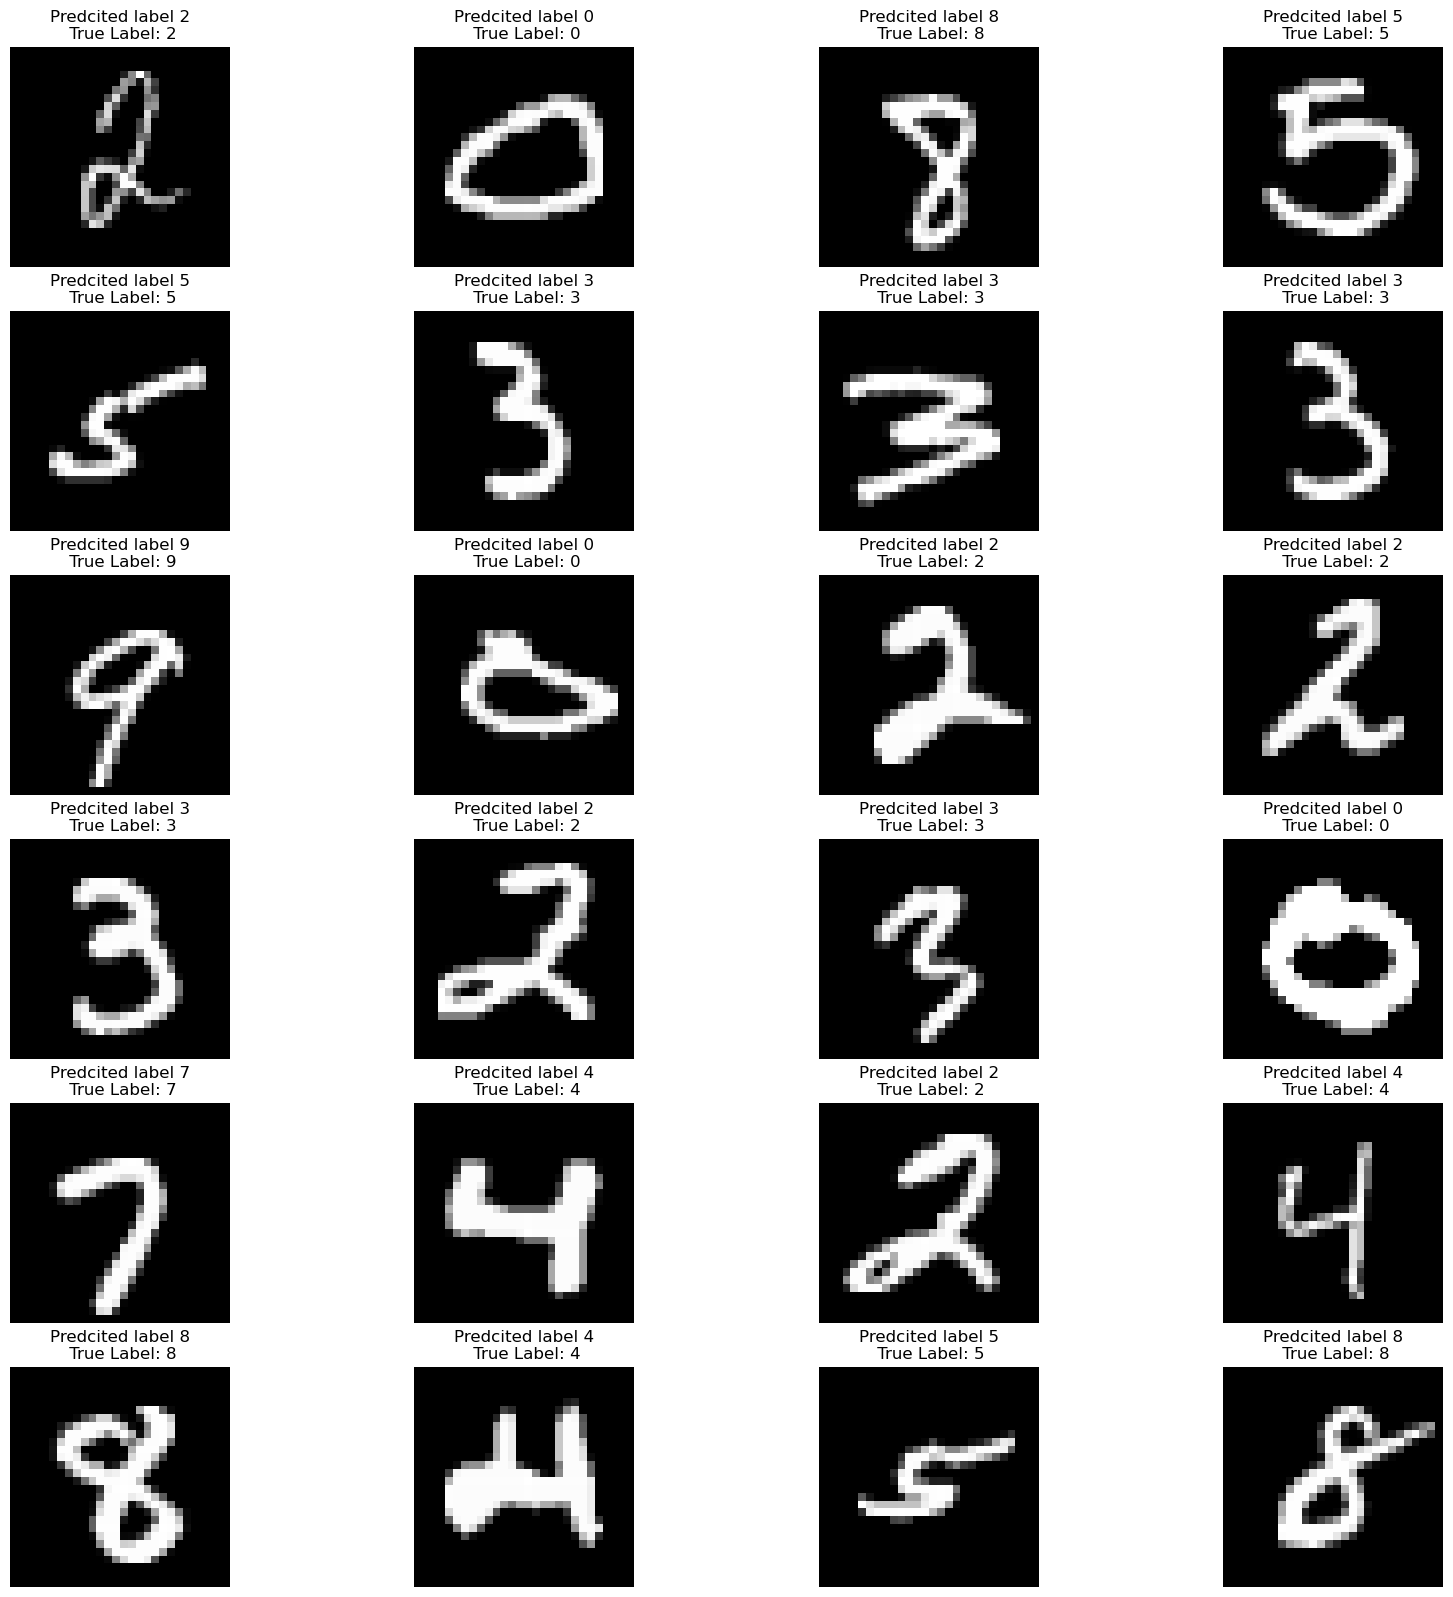

<Figure size 640x480 with 0 Axes>

In [19]:
evaluate_model(model, test_loader, device)

In [20]:
!hostname

ip-172-31-39-183


In [21]:
! cat /etc/os-release

PRETTY_NAME="Ubuntu 22.04.5 LTS"
NAME="Ubuntu"
VERSION_ID="22.04"
VERSION="22.04.5 LTS (Jammy Jellyfish)"
VERSION_CODENAME=jammy
ID=ubuntu
ID_LIKE=debian
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
UBUNTU_CODENAME=jammy
